In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler


from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel, set_seed
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

from datasets import load_from_disk


In [2]:

# Golbal variables
SEED_VAL = 42
set_seed(SEED_VAL)

MODEL_NAME = "gpt2-medium"
BOS_TOKEN = '<|startoftext|>'
EOS_TOKEN = '<|endoftext|>'
PAD_TOKEN = '<|pad|>'
MAX_LENGTH = 1024


In [2]:
# Load original data not sampled
trainset = pd.read_parquet("Data/checkpoint3.parquet")

In [4]:
texts=trainset['text'].to_list()


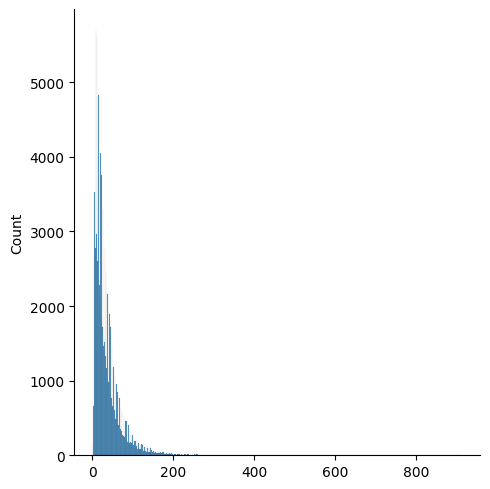

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME, bos_token=BOS_TOKEN, eos_token=EOS_TOKEN, pad_token=PAD_TOKEN)

doc_lengths = []

for text in texts:

    # get token count distribution including special tokens to asses context size issues
    tokens = tokenizer.encode(text, add_special_tokens=True, truncation=False, padding=False)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.displot(doc_lengths)
#plt.close()

In [11]:
# No document outside the context size
len(doc_lengths[doc_lengths > MAX_LENGTH])

0

In [12]:
np.max(doc_lengths)

912

In [13]:
np.average(doc_lengths)

35.70309

Since no documents are outside of the optimal context size of 1024. Therefore we do not have to use any chunking.

# GPT2 Tokenizer

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
print(f'Base BOS: {tokenizer.bos_token}')
print(f'Base EOS: {tokenizer.eos_token}')
print(f'Base PAD: {tokenizer.pad_token}')

# adjust global Variables according to models naming of special tokens

Base BOS: <|endoftext|>
Base EOS: <|endoftext|>
Base PAD: None


In [8]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME, bos_token=BOS_TOKEN, eos_token=EOS_TOKEN, pad_token=PAD_TOKEN) #gpt2-medium

print("The max model length is {} for this model".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [9]:
class TextDataset(Dataset):

  def __init__(self, txt_list, tokenizer, max_length):
    # Store features
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      # Encode text in between BOS and EOS
      encodings_dict = tokenizer(BOS_TOKEN + txt + EOS_TOKEN, truncation=True, max_length=max_length, padding="max_length")

      # Make features tensors and store
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 



In [10]:
# # Use GPU 0
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#torch.cuda.set_device(0)

In [11]:
torch.cuda.empty_cache()

In [12]:
def fine_tune_gpt2(train_data, output_dir=None):
    
    training_stats = []
    args = {}  # Initialize the args dictionary
    
    # Set the seed value all over the place to make this reproducible.
    set_seed(SEED_VAL)
    
    # Update args with seed and model parameters
    args['seed_val'] = SEED_VAL
    args['model_name'] = MODEL_NAME
    
    # Load GPT-2 model and tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME, bos_token=BOS_TOKEN, eos_token=EOS_TOKEN, pad_token=PAD_TOKEN) # add special tokens 
    model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)
    model.resize_token_embeddings(len(tokenizer)) # resize embeddings according to the updated tokenizer

    # Update args with tokenizer parameters
    args['bos_token'] = '50257'
    args['eos_token'] = '50256'
    args['pad_token'] = '50258'
    args['max_length'] = MAX_LENGTH #1024
    args['batch_size'] = 2
    args['learning_rate'] = 5e-4
    args['eps'] = 1e-8
    args['num_train_epochs'] = 5
    args['num_warmup_steps'] = 1e2
    
    # Load training dataset
    train_dataset = TextDataset(
        tokenizer=tokenizer,
        txt_list=train_data,
        max_length=args['max_length']
    )

    # Create data loader
    train_dataloader = DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=args['batch_size']
    )

    # Set up optimizer and learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=args['learning_rate'], eps=args['eps'])
    
    total_steps = len(train_dataloader) * args['num_train_epochs'] # calculate number of total steps
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=args['num_warmup_steps'],
        num_training_steps=total_steps
    )

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    args['device'] = device
    
    # Training loop
    model.train()
    # Iterate over each epoch
    for epoch in range(args['num_train_epochs']):
        # Expected completion time for one epoch 
        epoch_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
        # Set loss per batch to 0
        batch_loss = 0
        # Iterate over each batch
        for step, batch in enumerate(epoch_iterator):
            torch.cuda.empty_cache() # clean GPU cache
            inputs, attention_masks = batch # extract features
            # Move features to GPU
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)

            # Calculate probabilities
            outputs = model(inputs, attention_mask=attention_masks, labels=inputs)
            # Save loss
            loss = outputs.loss
            batch_loss += loss.item()
            # Perform backpropagation
            loss.backward()

            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        # Calculate average loss for one epoch
        avg_train_loss = batch_loss / len(train_dataloader)
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
            }
        )
    
    return args, training_stats, model
args, training_stats, model = fine_tune_gpt2(train_data=texts[:100])

/home/pop544167/.pyenv/versions/3.11.4/envs/project2/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5: 100%|██████████| 50/50 [00:30<00:00,  1.67it/s]


# Display Model Info

In [17]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 292 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 1024)
transformer.wpe.weight                                  (1024, 1024)

==== First Transformer ====

transformer.h.0.ln_1.weight                                  (1024,)
transformer.h.0.ln_1.bias                                    (1024,)
transformer.h.0.attn.c_attn.weight                      (1024, 3072)
transformer.h.0.attn.c_attn.bias                             (3072,)
transformer.h.0.attn.c_proj.weight                      (1024, 1024)
transformer.h.0.attn.c_proj.bias                             (1024,)
transformer.h.0.ln_2.weight                                  (1024,)
transformer.h.0.ln_2.bias                                    (1024,)
transformer.h.0.mlp.c_fc.weight                         (1024, 4096)
transformer.h.0.mlp.c_fc.bias                                (4096,)
transformer.h.0.mlp.c_proj.weight                       (4096

# Saving & Loading Fine-Tuned Model

In [19]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './models/GPT2-medium'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./models/GPT


### Save training loss


In [ ]:
# training_stats = [stat.cpu() for stat in training_stats]
pd.set_option('display.precision', 2)
df = pd.DataFrame(training_stats)
df

In [ ]:
plt.plot(df['epoch'], df['Training Loss'])
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.savefig(output_dir +'/training_loss.png')
